<a href="https://colab.research.google.com/github/infiniteDipia/CNN/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.6412 - loss: 0.6371 - val_accuracy: 0.5099 - val_loss: 1.6393
Epoch 2/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7101 - loss: 0.5658 - val_accuracy: 0.5170 - val_loss: 2.2687
Epoch 3/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7280 - loss: 0.5401 - val_accuracy: 0.6260 - val_loss: 0.6990
Epoch 4/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.7373 - loss: 0.5252 - val_accuracy: 0.6935 - val_loss: 0.6593
Epoch 5/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7446 - loss: 0.5136 - val_accuracy: 0.5808 - val_loss: 0.7163
Epoch 6/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7473 - loss: 0.5134 - val_accuracy: 0.5133 - val_loss: 2.1944
Epoch 7/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7587 - loss: 0.4974 - val_accuracy: 0.7752 - val_loss: 0.4787
Epoch 8/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7641 - loss: 0.4900 - val_accu

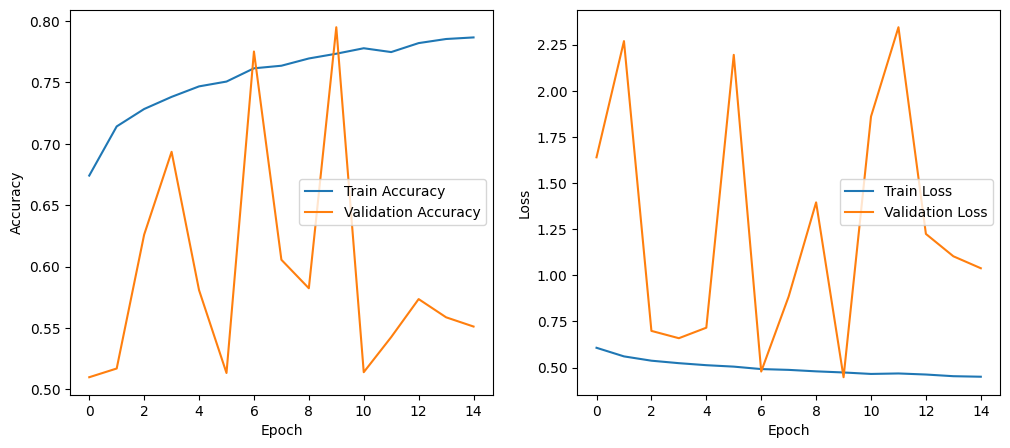

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# 1. 데이터셋 로드 및 전처리
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True)

IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 15

# 이미지 전처리 함수
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# 데이터 증강 함수
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

# 전처리 및 증강 적용
ds_train = ds_train.map(format_image).map(augment).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 2. ResNet50 베이스 모델 불러오기 (top 제외)
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet')
base_model.trainable = True  # 미세 조정을 위해 우선 활성화

# 3. 마지막 몇 개 레이어만 미세 조정 (예: 마지막 50개 레이어)
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 4. 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# 5. 모델 컴파일
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

# 6. 학습 및 검증
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS)

# 7. 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
